In [1]:
#15/01/2022
# Francisco Domínguez Mateos
# Fourier Features Net and Nerf
# From: https://github.com/matajoh/fourier_feature_nets

In [12]:
from collections import namedtuple
import copy
import csv
import os

#import cv2
#import fourier_feature_nets as ffn
import numpy as np
import matplotlib.pyplot as plt
#from ipywidgets import interact, fixed
#import scenepic as sp
import torch
#from visualizations import camera_to_world, VolumeRaycastingAnimation, world_to_camera, voxels_animation

device = "cuda"

%matplotlib inline

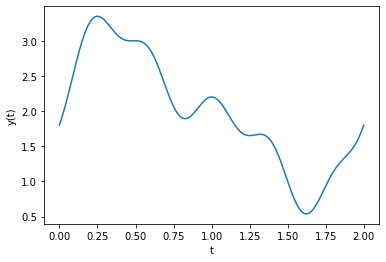

In [6]:
def func(t):
    return 2 + np.sin(t * np.pi) + 0.5*np.sin(2*t*np.pi) - 0.2*np.cos(5*t*np.pi)

num_samples = 32
sample_rate = 8
t = np.linspace(0, 2, num_samples * sample_rate)
y = func(t)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.plot(t, y)

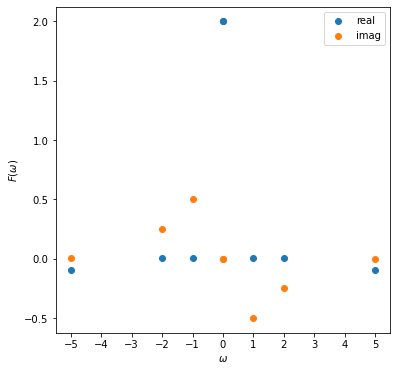

In [7]:
Y = np.fft.fft(y)
num_freqs = 4
order = np.argsort(np.abs(Y[:num_samples // 2]))[::-1]
freqs = np.fft.fftfreq(num_samples * sample_rate)

select = order[:4].tolist() + [-i for i in order[:4]]
plt.figure(figsize=(6, 6))
plt.xticks(np.arange(-5, 6))
plt.xlabel("$\omega$")
plt.ylabel("$F(\omega)$")
plt.scatter(freqs[select] * len(freqs), Y[select].real / len(freqs), label="real")
plt.scatter(freqs[select] * len(freqs), Y[select].imag / len(freqs), label="imag")
plt.legend()

In [13]:
def _plot_basis1d(basis=0):
    subset = np.zeros_like(Y)
    f = order[basis]
    subset[f] = Y[f]
    subset[-f] = Y[-f]
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(t, np.real(np.fft.ifft(subset)))
    plt.title("Basis @ {}hz".format(len(freqs) * freqs[f]))
    
    for f in order[:basis]:
        subset[f] = Y[f]
        subset[-f] = Y[-f]

    plt.subplot(122)
    plt.plot(t, np.real(np.fft.ifft(subset)))
    plt.plot(t, func(t))
    plt.title("Reconstruction")
    plt.show()

#interact(_plot_basis1d, basis=(0, 3))

In [14]:
## Hyperparameters ##

num_plot = 48
max_hidden = 10
num_steps = 10000
num_layers = 1
num_channels = 64

In [ ]:
dataset = ffn.SignalDataset.create(func, num_samples, sample_rate)
model = ffn.MLP(1, 1, num_layers, num_channels)
model.layers[-1].bias.data = dataset.train_y.mean()
torch.nn.init.xavier_normal_(model.layers[-1].weight, dataset.train_y.std())